In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import csv
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import wfdb

In [2]:
file_path = "/projects/bdlo/music-sudden-cardiac-death/subject-info.csv"
df = pd.read_csv(file_path, sep=";")
df.head()

,Patient ID,Follow-up period from enrollment (days),days_4years,Exit of` the study,Cause of death,Age,Gender (male=1),Weight (kg),Height (cm),Body Mass Index (Kg/m2),...,Angiotensin-II receptor blocker (yes=1),Anticoagulants/antitrombotics (yes=1),Betablockers (yes=1),Digoxin (yes=1),Loop diuretics (yes=1),Spironolactone (yes=1),Statins (yes=1),Hidralazina (yes=1),ACE inhibitor (yes=1),Nitrovasodilator (yes=1)
0,P0001,2065,1460,NaN,0,58,1,83,163,"31,2",...,0,1,1,1,1,0,0,0,1,0
1,P0002,2045,1460,NaN,0,58,1,74,160,"28,9",...,1,1,1,0,0,0,1,0,0,0
2,P0003,2044,1460,NaN,0,69,1,83,174,"27,4",...,1,1,1,1,1,0,0,0,0,0
3,P0004,2044,1460,NaN,0,56,0,84,165,"30,9",...,1,1,1,0,1,1,0,0,0,0
4,P0005,2043,1460,NaN,0,70,1,97,183,29,...,0,1,1,0,1,0,1,0,1,1


In [3]:
class HolterECGLoader(Dataset):
    def __init__(self, csv_file, ecg_dir, transform=None):
        self.dataset = pd.read_csv(csv_file, sep=";")
        self.ecg_dir = ecg_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        ecg_filename = os.path.join(self.ecg_dir, self.dataset.iloc[idx, 0])
        # ecg_signal = wfdb.rdrecord(ecg_filename)
        ecg_signal, _ = wfdb.rdsamp(ecg_filename)

        total_samples = ecg_signal.shape[0]
        target_samples = 14500000 # just take these because every ECG is abit uneven
        if total_samples >= target_samples:
            start_idx = (total_samples - target_samples) // 2 
            end_idx = start_idx + target_samples
            ecg_signal = ecg_signal[start_idx:end_idx]
        else:
            raise ValueError(f"ECG {ecg_filename} has only {total_samples} samples, which is too short for cropping.")

        # if self.transform:
        #     ecg_signal = self.transform(ecg_signal)
        return ecg_signal

Number of Leads: 3


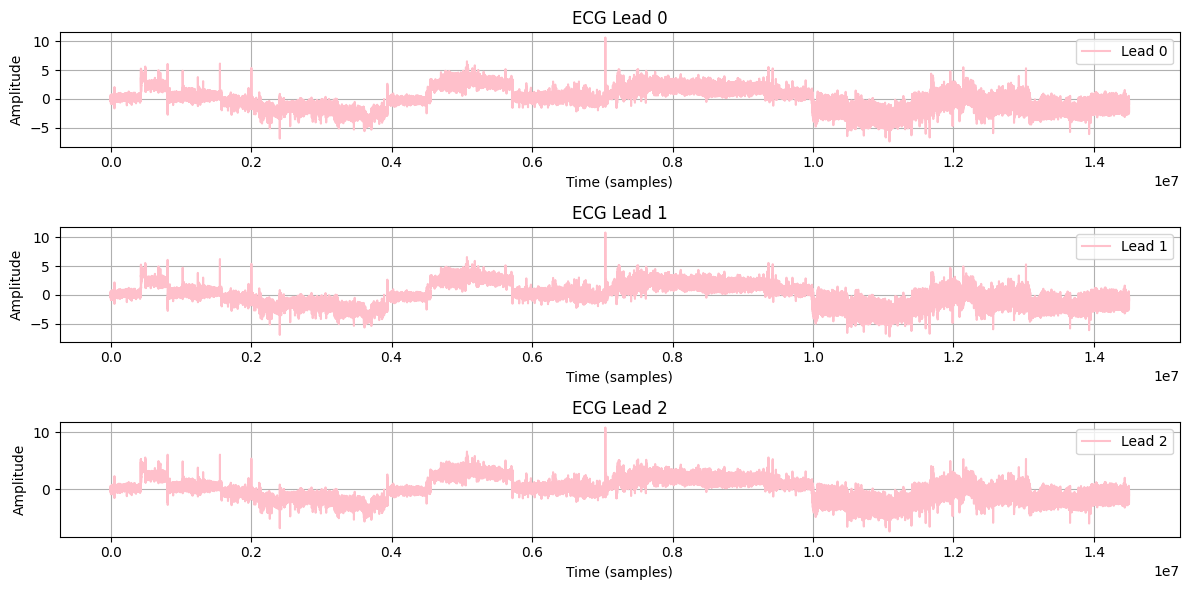

In [4]:
#test loader init
import matplotlib.pyplot as plt

csv_path = "/projects/bdlo/music-sudden-cardiac-death/subject-info-cleaned.csv"
ecg_dir = "/projects/bdlo/music-sudden-cardiac-death/Holter_ECG"

holterecg_dataset = HolterECGLoader(csv_file=csv_path, ecg_dir=ecg_dir)
sample_idx = 0 

ecg_signal = holterecg_dataset[sample_idx]
num_leads = ecg_signal.shape[1]

print(f"Number of Leads: {num_leads}")

plt.figure(figsize=(12, 6))
for i in range(num_leads):
    plt.subplot(3, 1, i + 1)
    plt.plot(ecg_signal[:, i], label=f"Lead {i}", color='pink')
    plt.title(f"ECG Lead {i}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [5]:
#test whole loader
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split

subset_indices = list(range(100))
holterecg_subset = Subset(holterecg_dataset, subset_indices)

train_idx, val_idx = train_test_split(list(range(len(holterecg_subset))), test_size=0.2)

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(holterecg_subset, batch_size=36, sampler=train_sampler)
val_loader = DataLoader(holterecg_subset, batch_size=36, sampler=val_sampler)

batch = next(iter(train_loader))
ecg_batch, filenames = batch  

print(f"Batch Size: {len(ecg_batch)}")  # Expected: 36
print(f"Batch Shape: {ecg_batch.shape}")  # Expected: (36, num_samples, 3)
print(f"First Few Filenames: {filenames[:5]}")  # Check file names


ValueError: ECG /projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0080 has only 13847800 samples, which is too short for cropping.